# Analyzing specific countries

## 1. Import modules and load data

In [ ]:
import pandas as pd
import numpy as np
import os
import altair as alt
import watermark
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [ ]:
data = pd.read_csv('data/All_merged.csv')
data.head()

,Country,iso2,iso3,Year,Annual CO2 emissions,GDP,GDP_growth,per_capita_electricity,population,fossil_share_energy,renewables_elec_per_capita,renewables_share_elec,renewables_share_energy
0,Afghanistan,AF,AFG,1989,2764855.0,NaN,NaN,NaN,11869000.0,NaN,NaN,NaN,NaN
1,Angola,AO,AGO,1989,4922750.0,1.020792e+10,0.041621,NaN,11455000.0,NaN,NaN,NaN,NaN
2,Albania,AL,ALB,1989,8976800.0,2.253090e+09,9.836549,NaN,3258000.0,NaN,NaN,NaN,NaN
3,United Arab Emirates,AE,ARE,1989,54186135.0,4.146500e+10,12.337891,9045.191,1726000.0,100.000,0.000,0.000,0.000
4,Argentina,AR,ARG,1989,117020422.0,7.663690e+10,-7.156950,1582.145,32148000.0,90.292,407.004,25.725,7.008


## 2. Calculate strength of trend

In this part, we are interested in similar patterns emerged through out the years that groups countries together.

Specifically, we look into four metrics within the last 10 years:
1. Annual GDP.
2. Annual CO2 emission.
3. Annual share of fossil in energy consumption.
4. Annual share of renewables in energy consumption.

We calculate the pearson correlation coeficient of these metrics with time, and visualize them.

In [ ]:
from tqdm import tqdm
res_dict = {
    'country':[],
    'GDP_cor':[],
    'CO2_cor':[],
    'fossil_cor':[],
    'renewable_cor':[]
}

### iterate through each countries and calculate correlation between metrics and time.
for country in tqdm(list(data.Country.unique())):
    sub_data = data[(data.Country==country) & (data.Year>=2010)]
    cor_df = sub_data[['Year','GDP','Annual CO2 emissions','fossil_share_energy','renewables_share_energy']].corr(method='pearson')
    res_dict['country'].append(country)
    res_dict['GDP_cor'].append(cor_df['Year']['GDP'])
    res_dict['CO2_cor'].append(cor_df['Year']['Annual CO2 emissions'])
    res_dict['fossil_cor'].append(cor_df['Year']['fossil_share_energy'])
    res_dict['renewable_cor'].append(cor_df['Year']['renewables_share_energy'])



100%|██████████| 184/184 [00:00<00:00, 1485.04it/s]


In [ ]:
res_df = pd.DataFrame(res_dict)
res_df

,country,GDP_cor,CO2_cor,fossil_cor,renewable_cor
0,Afghanistan,0.323065,0.131574,NaN,NaN
1,Angola,-0.441170,-0.704009,NaN,NaN
2,Albania,0.704919,-0.033864,NaN,NaN
3,United Arab Emirates,0.566906,-0.611971,-0.739405,0.739405
4,Argentina,-0.135520,-0.721762,-0.402228,0.419509
...,...,...,...,...,...
179,Samoa,0.882434,0.944417,NaN,NaN
180,Yemen,-0.383019,-0.830004,NaN,NaN
181,South Africa,-0.638654,-0.178877,-0.921525,0.945410
182,Zambia,-0.183569,0.963144,NaN,NaN


Next, we want to assign a value to each countries to represent how strong they are in the recognized patterns. 

We times the correlation coefficient together, so that only counties with strong correlation in all these analyses are regarded as "strong pattern".

In [ ]:
res_df['abs_GDP_cor_times_CO2_cor'] = np.abs(res_df.GDP_cor*res_df.CO2_cor)
res_df['abs_GDP_cor_times_CO2_cor_times_renewable_cor'] = np.abs(res_df.GDP_cor*res_df.CO2_cor*res_df.renewable_cor)
## take the absolute values
res_df

,country,GDP_cor,CO2_cor,fossil_cor,renewable_cor,abs_GDP_cor_times_CO2_cor,abs_GDP_cor_times_CO2_cor_times_renewable_cor
0,Afghanistan,0.323065,0.131574,NaN,NaN,0.042507,NaN
1,Angola,-0.441170,-0.704009,NaN,NaN,0.310588,NaN
2,Albania,0.704919,-0.033864,NaN,NaN,0.023871,NaN
3,United Arab Emirates,0.566906,-0.611971,-0.739405,0.739405,0.346930,0.256522
4,Argentina,-0.135520,-0.721762,-0.402228,0.419509,0.097813,0.041033
...,...,...,...,...,...,...,...
179,Samoa,0.882434,0.944417,NaN,NaN,0.833386,NaN
180,Yemen,-0.383019,-0.830004,NaN,NaN,0.317907,NaN
181,South Africa,-0.638654,-0.178877,-0.921525,0.945410,0.114241,0.108004
182,Zambia,-0.183569,0.963144,NaN,NaN,0.176803,NaN


## 3. Word could visualization with GDP trend and CO2 emission trend

In [ ]:
##### prepare datasets for visualization
comb_name_list = [
    '- GDP, - CO2 emission',
    '+ GDP, - CO2 emission',
    '- GDP, + CO2 emission',
    '+ GDP, + CO2 emission',
]

comb_df_list = [
    res_df[(res_df.GDP_cor<0) & (res_df.CO2_cor<0)],
    res_df[(res_df.GDP_cor>0) & (res_df.CO2_cor<0)],
    res_df[(res_df.GDP_cor<0) & (res_df.CO2_cor>0)],
    res_df[(res_df.GDP_cor>0) & (res_df.CO2_cor>0)]
]




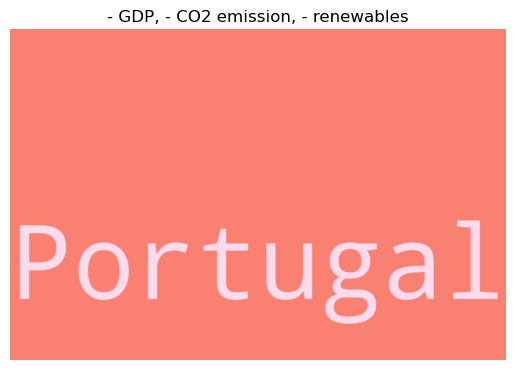

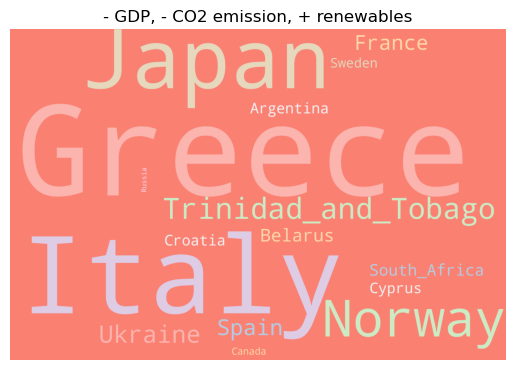

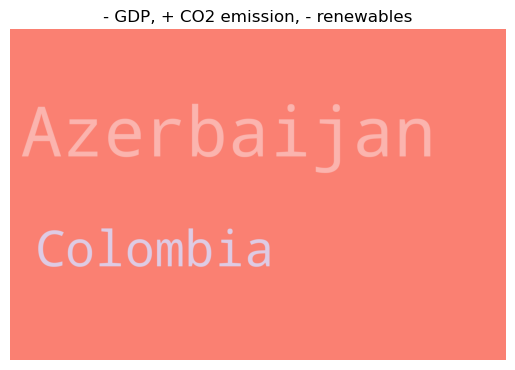

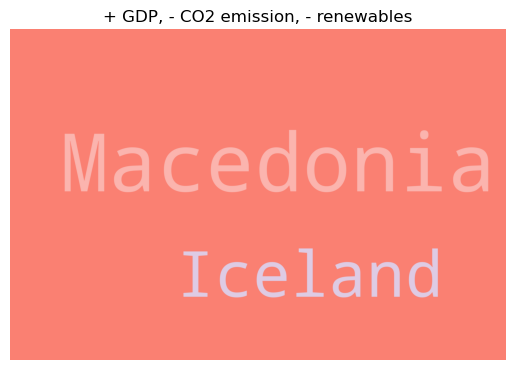

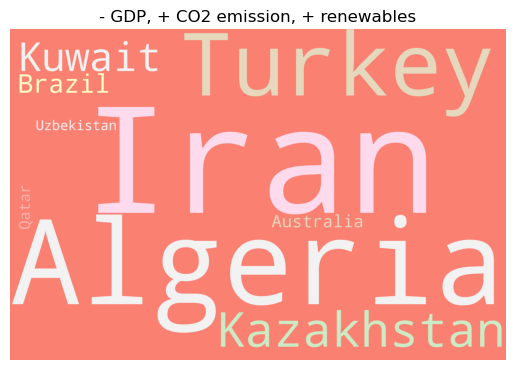

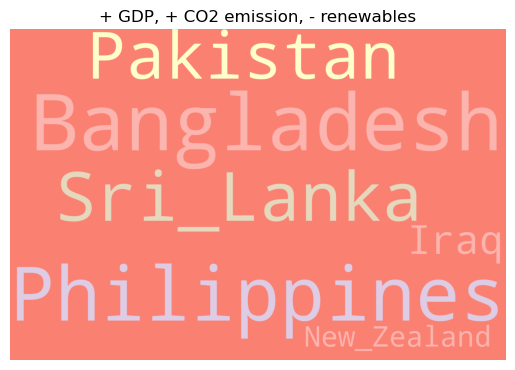

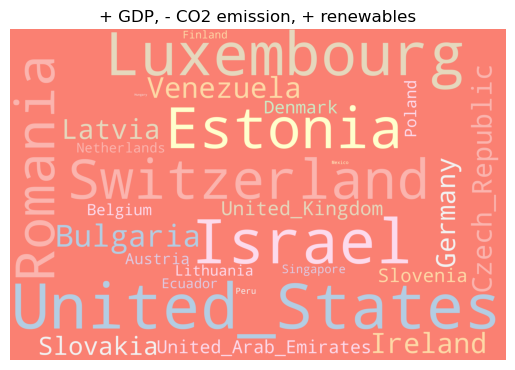

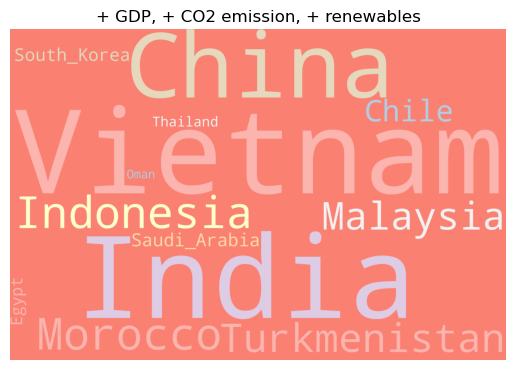

In [ ]:
for name, df in zip(comb_name_list,comb_df_list):
    ################
    sub_res_df = df
    text = []
    for index,line in sub_res_df.iterrows(): ## for each of the countries
        cy_name = line['country'].replace(" ","_")    ## replace space because word could do not allow space
        text.extend([cy_name]*int((line['abs_GDP_cor_times_CO2_cor'] * 1000))) ##### transform the correlation values to number of words count
    text = ",".join(text)                                                       #### so that word size represent the how strong the pattern is in each countries

    word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="salmon", # purple, salmon
        colormap="Pastel1", # Set2, Pastel1
        collocations=False,
    ).generate(text)

    plt.imshow(word_cloud)
    plt.axis("off")
    plt.title(name)
    plt.show()


## 4. Word could visualization with GDP trend, CO2 emission trend, and renewales trend

In [ ]:
##### prepare datasets for visualization
comb_name_list = [
    '- GDP, - CO2 emission, - renewables',
    '- GDP, - CO2 emission, + renewables',
    '- GDP, + CO2 emission, - renewables',
    '+ GDP, - CO2 emission, - renewables',
    '- GDP, + CO2 emission, + renewables',
    '+ GDP, + CO2 emission, - renewables',
    '+ GDP, - CO2 emission, + renewables',
    '+ GDP, + CO2 emission, + renewables',
]

comb_df_list = [
    res_df[(res_df.GDP_cor<0) & (res_df.CO2_cor<0) & (res_df.renewable_cor<0)],
    res_df[(res_df.GDP_cor<0) & (res_df.CO2_cor<0) & (res_df.renewable_cor>0)],
    res_df[(res_df.GDP_cor<0) & (res_df.CO2_cor>0) & (res_df.renewable_cor<0)],
    res_df[(res_df.GDP_cor>0) & (res_df.CO2_cor<0) & (res_df.renewable_cor<0)],
    res_df[(res_df.GDP_cor<0) & (res_df.CO2_cor>0) & (res_df.renewable_cor>0)],
    res_df[(res_df.GDP_cor>0) & (res_df.CO2_cor>0) & (res_df.renewable_cor<0)],
    res_df[(res_df.GDP_cor>0) & (res_df.CO2_cor<0) & (res_df.renewable_cor>0)],
    res_df[(res_df.GDP_cor>0) & (res_df.CO2_cor>0) & (res_df.renewable_cor>0)]
]

# color_map1 = [
#     "gray","salmon","gray","gray","salmon","gray","salmon","salmon"
# ]

color_map1 = [
    "purple","salmon","purple","purple","salmon","purple","salmon","salmon"
]

color_map2 = [
    "Set2","Pastel1","Set2","Set2","Pastel1","Set2","Pastel1","Pastel1"
]


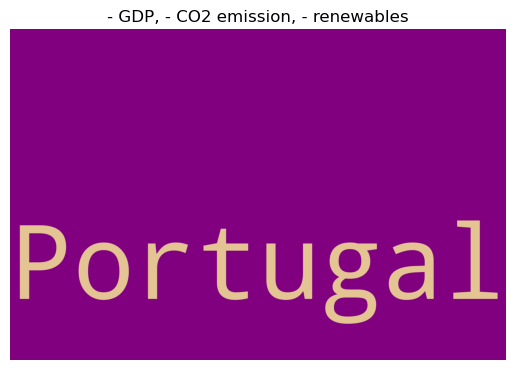

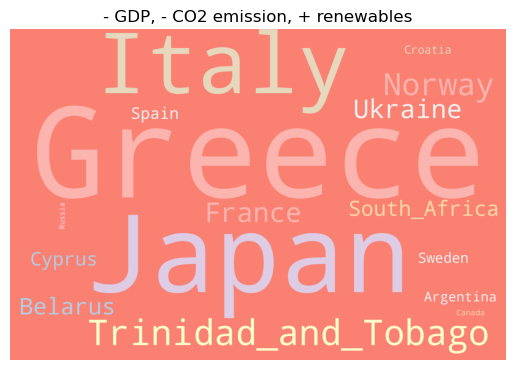

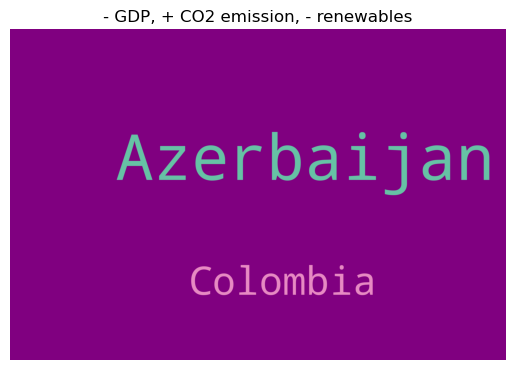

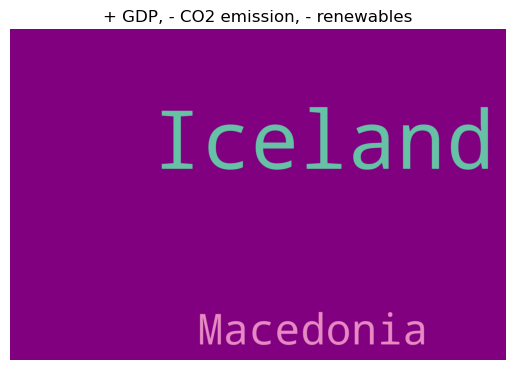

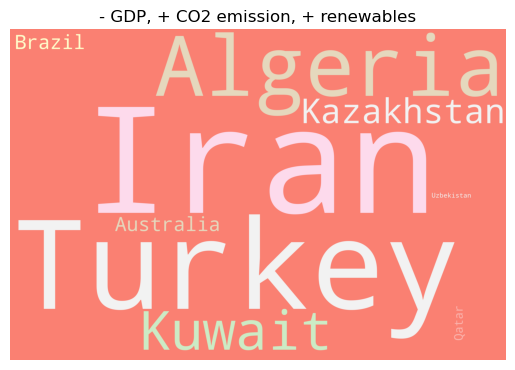

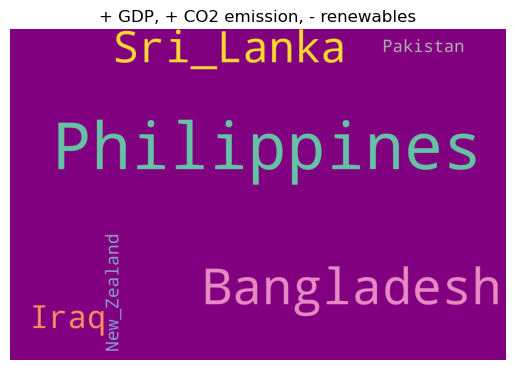

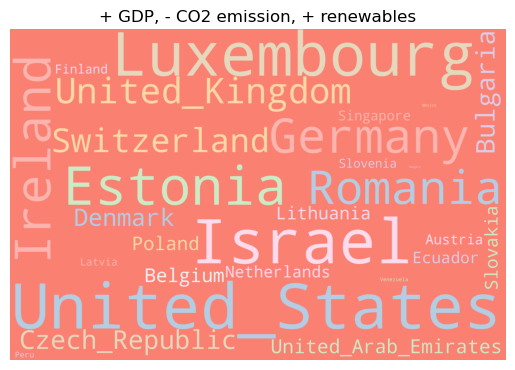

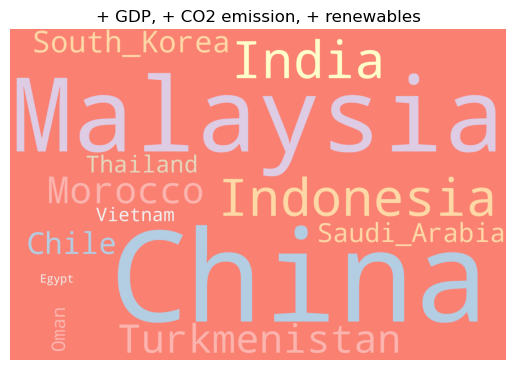

In [ ]:
for name, df, c1, c2 in zip(comb_name_list,comb_df_list,color_map1,color_map2):
    ################
    text = []
    for index,line in df.iterrows(): ## for each of the countries
        cy_name = line['country'].replace(" ","_")  ## replace space because word could do not allow space
        text.extend([cy_name]*int((line['abs_GDP_cor_times_CO2_cor_times_renewable_cor'] * 10000))) ##### transform the correlation values to number of words count
    text = ",".join(text)                                                                           #### so that word size represent the how strong the pattern is in each countries

    word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color=c1, # purple, salmon
        colormap=c2, # Set2, Pastel1
        collocations=False,
    ).generate(text)

    plt.imshow(word_cloud)
    plt.axis("off")
    plt.title(name)
    plt.show()

## 5. Plot these four metrics on the same chart for some countries

In [ ]:
### define a standardization function
def standardize(a):
    return (a-np.nanmean(a))/np.nanstd(a)


In [ ]:
### given country names, return the it's dataset with logged, standardized values
def get_sub_country_data(C='United States'):
    sub_data = data[(data.Country==C) & (data.Year>1989)]
    sub_data['log GDP'] = standardize(np.log(sub_data.GDP))
    sub_data['log Annual CO2 emissions'] = standardize(np.log(sub_data['Annual CO2 emissions']))
    sub_data['log Fossil share energy'] = standardize(np.log(sub_data['fossil_share_energy']))
    sub_data['log Renewables share energy'] = standardize(np.log(sub_data['renewables_share_energy']))
    return sub_data



In [ ]:
### given dataset, return melted df, in long form
def make_melt_sub_data(sub_data):
    melt_sub_data = sub_data[['Year', 'log GDP', 
                        'log Annual CO2 emissions', 
                        'log Fossil share energy','log Renewables share energy']].melt(id_vars='Year')
    return melt_sub_data

In [ ]:
# define three events (Global Depression, Paris Agreement, Covid-19)
# This is the same with that in 4.Analyze_critial_events.ipynb
event_source = alt.pd.DataFrame([{
            "start": 2008,
            "end": 2009,
            "event": 'Global Depression',
            'y':2.25,
            'x':2006
        },
        {
            "start": 2016,
            "end": 2017,
            "event": 'Paris Agreement',
            'y':2.25,
            'x':2015
        },
        {
            "start": 2019,
            "end": 2020,
            "event": 'Covid Pandemic',
            'y':2.25,
            'x':2019
        }])

In [ ]:
### given dataset, event and country names, return line charts
def plot_lines(melt_sub_data, event_source, C):

    #### mark even rectangles
    event = alt.Chart(event_source).mark_rect(opacity=0.3).encode(
        x='start:O',
        x2='end:O',
    )

    #### mark event annotation
    text1 = alt.Chart(event_source).mark_text(
    ).encode(
        x = alt.X('x:O'),
        y = alt.Y('y:Q'),
        text=alt.Text('event')
    )

    ### markl lines 
    line = alt.Chart(melt_sub_data,title=f'Changes in {C}').mark_line().encode(
        x = alt.X('Year:O'),
        y = alt.Y('value:Q', title='Standardized values'),
        color = alt.Color('variable',  title='Features')
    ).properties(width=700,height=300)

    ### mark point each year
    points = alt.Chart(melt_sub_data,title=f'Changes in {C}').mark_circle(size=100).encode(
        x = alt.X('Year:O', title='Year'),
        y = alt.Y('value:Q', title='Standardized values'),
        color = alt.Color('variable',  title='Features'),
    ).properties(width=700,height=300)

    return (line+points + event + text1)



Next, we can just plot the countries that interest us

In [ ]:
fig_list = []
for C in tqdm(['China', 'United States', 'Greece', 'Japan', 'Denmark', 
                'Germany', 'Iceland', 'Russia','France','South Korea','South Africa','India']):

    sub_data = get_sub_country_data(C)
    melt_sub_data = make_melt_sub_data(sub_data)
    fig_list.append(plot_lines(melt_sub_data, event_source, C))

### vertical concate these country charts
alt.vconcat(*fig_list).configure_title(fontSize=20)

100%|██████████| 12/12 [00:00<00:00, 42.62it/s]


alt.VConcatChart(...)

In [ ]:
%load_ext watermark
%watermark  --iversion

pandas    : 1.4.1
geopandas : 0.10.2
numpy     : 1.21.6
matplotlib: 3.5.1
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:24:02) 
[Clang 11.1.0 ]
watermark : 2.3.1
altair    : 4.2.0



In [ ]:
print(watermark.watermark(packages="numpy,pandas,altair,watermark,geopandas,matplotlib,wordcloud,openpyxl,tqdm,geopandas"))